<a href="https://colab.research.google.com/github/kbtran93/aapl-stock-prediction/blob/main/aapl_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Stock Prediction

Apple Inc. is an American multinational technology company that specializes in consumer electronics, software and online services headquartered in Cupertino, California, United States. Apple is the largest information technology company by revenue (totaling US$365.8 billion in 2021) and as of January 2021, it is the world's most valuable company, the fourth-largest personal computer vendor by unit sales and second-largest mobile phone manufacturer. It is one of the Big Five American information technology companies, alongside Alphabet, Amazon, Meta, and Microsoft.

In this small project, we want to do a time-series analysis of Apple's stock values from 2010 to the present. We also attempt to forecast future stock prices using the ARIMA model.

Firstly, we import libraries that are essential for this study.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as ysf 
import seaborn as sns
import numpy as np
from dateutil.parser import parse
%matplotlib inline

## 1. Data Processing

The first thing we do is extracting the historical stock data from Yahoo Finance database using the yfinance library. Then, we keep only the key columns containing the data that we need in the dataframe (Date, Open, High, Close, Volume).

In [5]:
# Define the ticker symbol
tickerSymbol = 'AAPL'

# Get data on this ticker
tickerData = ysf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2022-5-09')

# Keep only the key columns
tickerDf = tickerDf[['Open', 'High', 'Low', 'Close', 'Volume']]

# Take a glimpse at the data
print(tickerDf.head(5))

                Open      High       Low     Close     Volume
Date                                                         
2010-01-04  6.517375  6.550048  6.485312  6.535086  493729600
2010-01-05  6.553101  6.583332  6.511876  6.546383  601904800
2010-01-06  6.546383  6.572340  6.435536  6.442255  552160000
2010-01-07  6.466072  6.473706  6.383624  6.430344  477131200
2010-01-08  6.421795  6.473707  6.383931  6.473096  447610800


Then we conduct a summary to identify the anomalies in the data.

In [6]:
# Check the structrue and the format of the dataframe
tickerDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2010-01-04 to 2022-05-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3108 non-null   float64
 1   High    3108 non-null   float64
 2   Low     3108 non-null   float64
 3   Close   3108 non-null   float64
 4   Volume  3108 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 145.7 KB


By looking at the summary we can observe:
*   There are 3108 observations
*   Data types included are float64 and int64
*   There are no missing values on any of the records





Then we examine the descriptive statistics of the dataset.

In [7]:
tickerDf.describe()

,Open,High,Low,Close,Volume
count,3108.000000,3108.000000,3108.000000,3108.000000,3.108000e+03
mean,44.387772,44.864892,43.916976,44.409443,2.653229e+08
std,43.271947,43.802107,42.755250,43.300164,2.246845e+08
min,5.874278,5.985125,5.809542,5.864508,4.100000e+07
25%,16.387121,16.553004,16.199290,16.394219,1.068194e+08
50%,26.537011,26.707852,26.225087,26.426189,1.781293e+08
75%,49.690638,50.185564,49.259745,49.745086,3.612987e+08
max,182.130025,182.439174,178.629624,181.511703,1.880998e+09


From the output, we can infer that the average closing price for Apple's stock is 44.4 USD. However the median closing price is 26.4 USD.

Next, visualise the price per day of the stock.

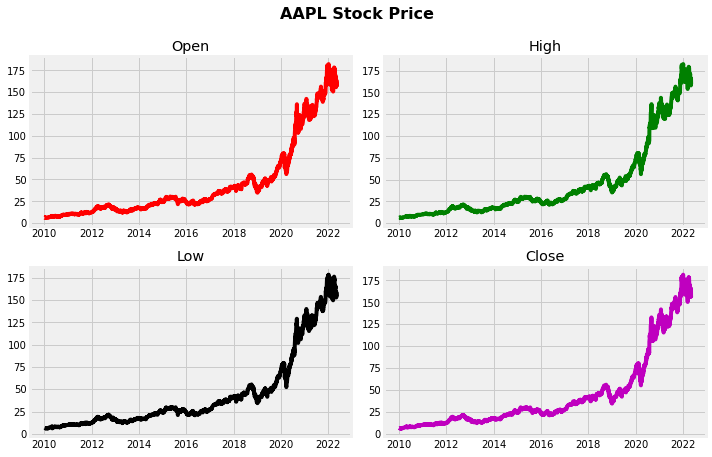

In [8]:
# Create figure
fig = plt.figure(figsize=(10,6))

# Create each subplot individually
ax1 = plt.subplot(2, 2, 1)
plt.plot(tickerDf['Open'], linestyle='solid', color='r')
ax2 = plt.subplot(2, 2, 2)
plt.plot(tickerDf['High'], linestyle='solid', color='green')
ax3 = plt.subplot(2, 2, 3)
plt.plot(tickerDf['Low'], linestyle='solid', color='black')
ax4 = plt.subplot(2, 2, 4)
plt.plot(tickerDf['Close'], linestyle='solid', color='m')

# Title
plt.suptitle('AAPL Stock Price', x = 0.5, y = 1.05, fontweight = 'bold', fontsize = 16)

ax1.set_title('Open')
ax2.set_title('High')
ax3.set_title('Low')
ax4.set_title('Close')

# Auto adjust
plt.tight_layout()

# Display
plt.show()

The stock prices move on a positive trend and very close to each other. The trend slopes are gentle from 2010 to circa 2019, but turn steep from 2019 onwards. Looking at the plot, there are signs of seasonality, so we suspect our time series are non-stationary.

## 2. Time Series Analysis

### 2.1. Check for Stationarity

Firstly, in order to conduct a time series analysis, we have to check if the data is stationary or not. Hence, we use the **Augmented Dickey-Fuller test**. The hypotheses accompanied with the test are:
*   **Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
*   **Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

Therefore, we want to define a function to conduct ADF tests on the columns of the dataframe and a function to plot the moving statistics.

In [37]:
def adfuller_test(series, signif=0.05):
  
  # Testing and return output
  x = adfuller(series, autolag='AIC')

  #using dictionary saves different data types (float, int, boolean)
  output = {'Test Statistic': x[0], 
            'P-value': x[1], 
            'Number of lags': x[2], 
            'Number of observations': x[3],
            f'Reject (signif. level {signif})': x[1] < signif }

  for key, val in x[4].items():
    output[f'Critical value {key}'] = val

  return pd.Series(output)

def plot_moving(series):
  # Determining rolling statistics
  movingAverage = series.rolling(window=12).mean()
  movingStd = series.rolling(window=12).std()

  # Plot rolling statistics
  fig = plt.figure(figsize=(10,6))
  original =  plt.plot(series, color = 'blue', label = 'Original')
  mean_plot = plt.plot(movingAverage, color = 'red', label = 'Rolling Average')
  std_plot = plt.plot(movingStd, color = 'black', label = 'Rolling Standard Deviation')
  plt.legend(loc = 'best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show()

Check if the series in the dataframe are stationary or not.

In [39]:
# ADF Test on the dataframe
tickerDf.apply(lambda x: adfuller_test(x), axis=0)

,Open,High,Low,Close,Volume
Test Statistic,1.972737,1.955305,1.426387,2.084235,-3.115245
P-value,0.998636,0.998612,0.997231,0.998773,0.025445
Number of lags,28,29,9,29,28
Number of observations,3079,3078,3098,3078,3079
Reject (signif. level 0.05),False,False,False,False,True
Critical value 1%,-3.432476,-3.432476,-3.432463,-3.432476,-3.432476
Critical value 5%,-2.862479,-2.862479,-2.862473,-2.862479,-2.862479
Critical value 10%,-2.56727,-2.56727,-2.567267,-2.56727,-2.56727


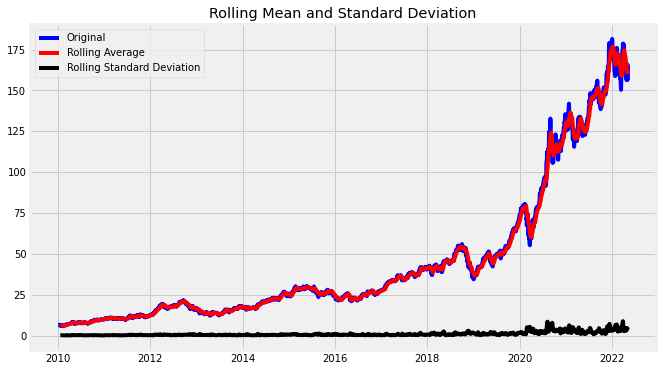

In [40]:
# Plotting the moving statistics for the closing price
plot_moving(tickerDf['Close'])

Examining the p-values, for the Open, High, Low, Close columns, we cannot reject the null hypothesis at significance level 0.05. Hence, they are non-stationary time series and have time-dependent structure. Meanwhile, the Volume attribute is stationary.
\
We may need to remove seasonality and trend from our series in order to do a time series analysis. Through this process, the resulting series will become stationary.

### 2.2 Time Series Decomposition

Firstly, we want to separate the trend and seasonality for closing price

<Figure size 432x288 with 0 Axes>

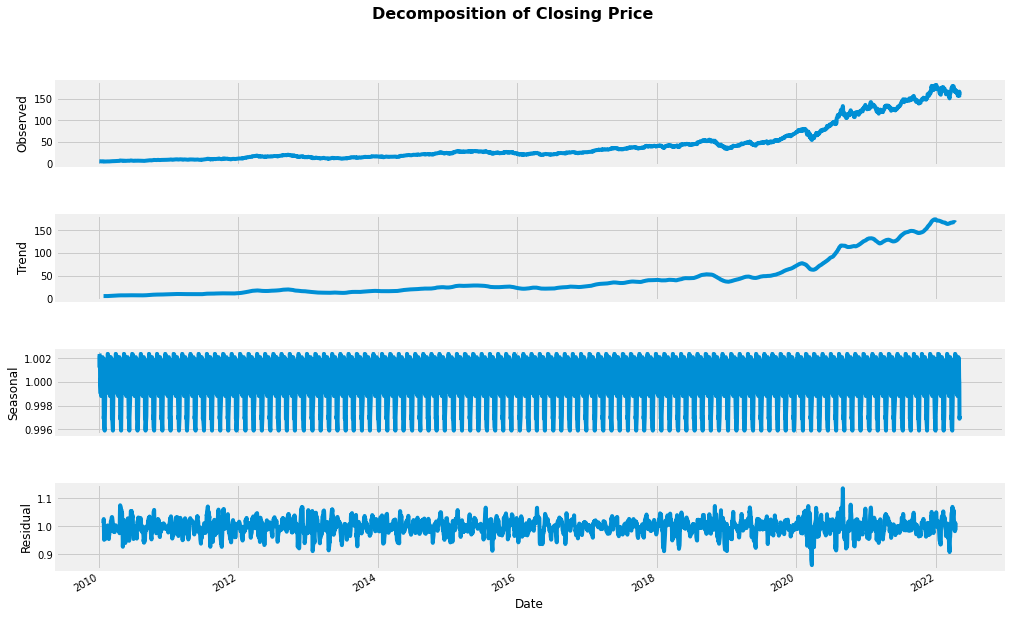

In [21]:
res_close = seasonal_decompose(tickerDf['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = res_close.plot()  
plt.suptitle('Decomposition of Closing Price', x = 0.55, y = 1.05, fontweight = 'bold', fontsize = 16)
fig.set_size_inches(16, 9)

To normalize the seasonality of the time series, we conduct a differencing of the log-transformed data and the shifted log value.


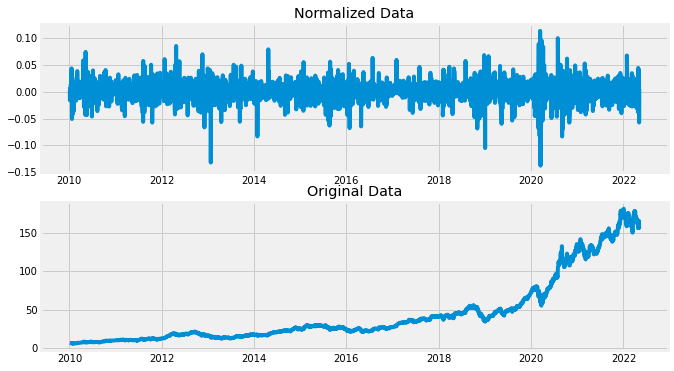

In [24]:
# Log transformation of closing price
log_close = np.log(tickerDf['Close'])

# Differencing with lag 1
log_diff = log_close - log_close.shift()

# Plotting the normalized data
fig, axs = plt.subplots(2)
axs[0].plot(log_diff)
axs[0].set_title('Normalized Data')
axs[1].plot(tickerDf.Close)
axs[1].set_title('Original Data')
fig.set_size_inches(10, 6)

Now, we check the stationarity of the deseasonalized closing price data with the **Augmented Dickey-Fuller test** and plot the moving average and standard deviation.

In [41]:
adfuller_test(log_diff.dropna())

Test Statistic                -14.18398
P-value                             0.0
Number of lags                       13
Number of observations             3093
Reject (signif. level 0.05)        True
Critical value 1%             -3.432466
Critical value 5%             -2.862475
Critical value 10%            -2.567268
dtype: object

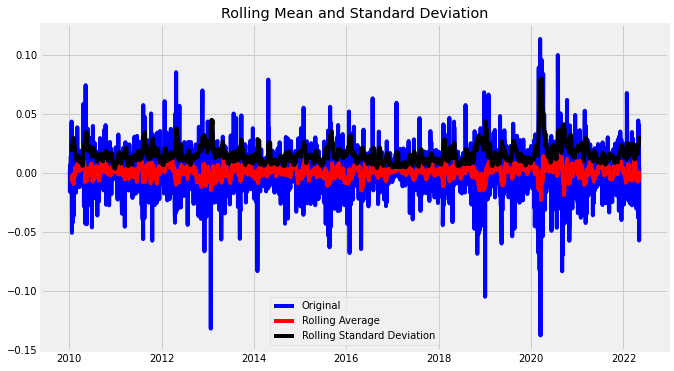

In [43]:
plot_moving(log_diff.dropna())

The p_value < 0.05, so we can reject the null hypothesis, which means the normalized closing price data is stationary. The rolling average and standard deviation after deseasonalization is much better than the ones from before as they show no signs of trend or seasonality anymore.   

## 3. Forecasting

We decided to use the ARIMA models to forecast the closing price of Apple's stock. ARIMA, which stands for 'Auto Regressive Integrated Moving Average,' is a class of models that 'explains' a given time series based on its own historical values, that is, its own lags and prediction and the lagged  errors, such that equation may be used to anticipate future values. ARIMA models are basic but effective. ARIMA models are also one of the most extensively used time series forecasting methodologies. As a result, we picked them for our forecasts.

First, we have to split our closing price data into training data and test data

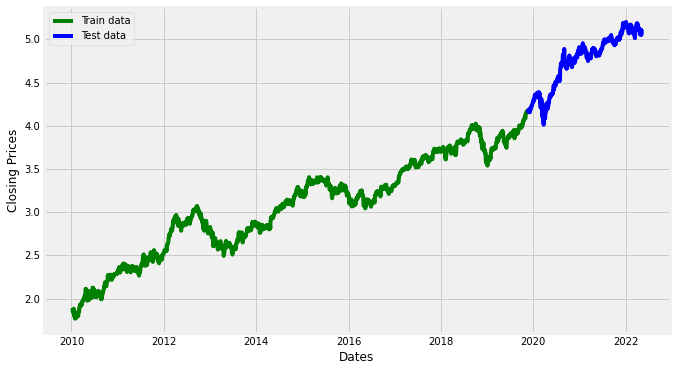

In [45]:
# Split data into train and test set

train_data, test_data = log_close[3:int(len(log_close)*0.8)], log_close[int(len(log_close)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Normally, we have to specify 3 parameters in ARIMA(p, d, q) models:

*   **p** is the number of autoregressive terms or the number of “lag observations.” It is also called the “lag order,” and it determines the outcome of the model by providing lagged data points.
*   **d** is known as the degree of differencing. it indicates the number of times the lagged indicators have been subtracted to make the data stationary.
*   **q** is the number of forecast errors in the model and is also referred to as the size of the moving average window.

\
However, when we use **auto_arima** function, it seeks the most optimal parameters and returns a fitted ARIMA model.

In [48]:
# Import library
from pmdarima import auto_arima

# Fit the train data into the model
model = auto_arima(train_data, start_p=0, start_q=0,
                   test='adf',       # use adftest to find             optimal 'd'
                   max_p=3, max_q=3, # maximum p and q
                   m=1,              # frequency of series
                   d=None,           # let model determine 'd'
                   seasonal=False,   # No Seasonality
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)
print(model.summary())

ImportError: ignored